___
# Report classification using BoW
___

In [1]:
import numpy as np
import pandas as pd
from utils.dataset import labels2cat
from utils import text, dev, eval_ml, prod
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

___
# Load reports

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Rename label column
df.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df.y = labels2cat(df.y)

# Clean text
df['clean_text'] = df.order_results.apply(text.clean_text)

# Define features and labels
X = df.clean_text 
y = df.y.cat.codes
groups = df.patient_id

df.y.value_counts()

y
Negative    199
Positive     32
Name: count, dtype: int64

___
# Model selection
### Quick&dirty trying a few algorithms

In [3]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')

clfs = (
    SVC(probability=True),
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced", random_state=42),
    MultinomialNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight="balanced", random_state=42),
    RandomForestClassifier(class_weight="balanced", random_state=42),
    GradientBoostingClassifier(random_state=42),
)

for clf in clfs:
    pipe = make_pipeline(vectorizer, clf)
    dev.score_cv(pipe, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
SVC(probability=True)
train time: 3.268s
Average precision score: 0.756 (+/- 0.27)
ROC AUC score: 0.934 (+/- 0.07)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
train time: 0.465s
Average precision score: 0.746 (+/- 0.28)
ROC AUC score: 0.930 (+/- 0.07)

________________________________________________________________________________
Training with 10-fold cross-validation:
MultinomialNB()
train time: 0.389s
Average precision score: 0.592 (+/- 0.29)
ROC AUC score: 0.837 (+/- 0.14)

________________________________________________________________________________
Training with 10-fold cross-validation:
KNeighborsClassifier()
train time: 0.649s
Average precision score: 0.540 (+/- 0.23)
ROC AUC score: 0.882 (+/- 0.09)

___

### Proper model comparison with nested CV 

In [ ]:
clfs = []
search_modes = []
param_grids = []

# # SVC
# clfs.append(SVC(probability=True))
# search_modes.append('grid')

# c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
# param_grid = {"svc__C": c}
# param_grids.append(param_grid)

# # Logreg
# clfs.append(LogisticRegression(solver='saga', penalty='elasticnet', 
#                                max_iter=5000, class_weight='balanced', random_state=42))
# search_modes.append('grid')

# c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
# l1_ratio = [1.0, 0.75, 0.5, 0.25, 0.0]
# param_grid = {
#     'logisticregression__C': c, 
#     'logisticregression__l1_ratio': l1_ratio,
# }
# param_grids.append(param_grid)

# MNB
clfs.append(MultinomialNB())
search_modes.append('grid')

alpha = [1e-5, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
param_grid = {"multinomialnb__alpha": alpha}
param_grids.append(param_grid)

# # GB
# clfs.append(GradientBoostingClassifier(random_state=42))
# search_modes.append('random')

# n_estimators = [100, 200, 300, 400]
# max_depth = [2, 4, 6, 8]
# learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
# subsample = [0.3, 0.5, 0.8, 1.0]
# param_grid = {
#     "gradientboostingclassifier__n_estimators": n_estimators,
#     "gradientboostingclassifier__max_depth": max_depth, 
#     "gradientboostingclassifier__learning_rate": learning_rate, 
#     "gradientboostingclassifier__subsample": subsample
# }
param_grids.append(param_grid)

In [ ]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')

for clf, search_mode, param_grid in zip(clfs, search_modes, param_grids):
    
    pipe = make_pipeline(vectorizer, clf)
    dev.benchmark_nestedcv(pipe, search_mode, param_grid, X, y, groups)

### Tune the final model

In [ ]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
clf = GradientBoostingClassifier(random_state=42)
pipe = make_pipeline(vectorizer, clf)

n_estimators = [100, 200, 300, 400]
param_grid = {"gradientboostingclassifier__n_estimators": n_estimators}

best_params = dev.search_params(pipe, 'grid', param_grid, X, y, groups)
pipe.set_params(**best_params)

In [ ]:
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
subsample = [0.3, 0.5, 0.8, 1.0]

param_grid = {"gradientboostingclassifier__max_depth": max_depth, 
              "gradientboostingclassifier__learning_rate": learning_rate, 
              "gradientboostingclassifier__subsample": subsample
             }

best_params = dev.search_params(pipe, 'random', param_grid, X, y, groups, refit=False, verbose=True)
best_model = pipe.set_params(**best_params)

In [4]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
clf = GradientBoostingClassifier(random_state=42, 
                                 n_estimators=400,
                                 subsample=0.3, 
                                 max_depth=6,
                                 learning_rate=0.1)
best_model = make_pipeline(vectorizer, clf)

___
# Model evaluation
### Evaluate the final model using CV

In [5]:
# Model performance in each CV fold
dev.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = dev.predict_cv(best_model, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
GradientBoostingClassifier(max_depth=6, n_estimators=400, random_state=42,
                           subsample=0.3)
train time: 13.822s
Average precision score: 0.955 (+/- 0.12)
ROC AUC score: 0.985 (+/- 0.04)



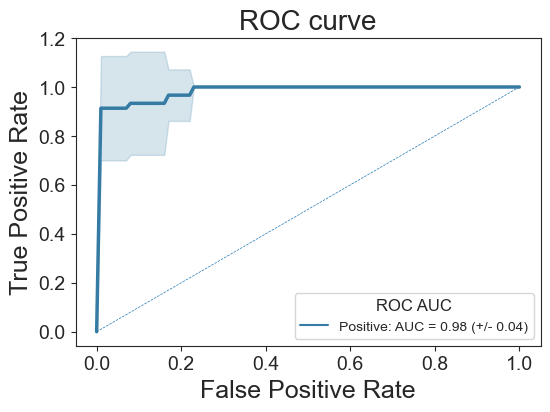

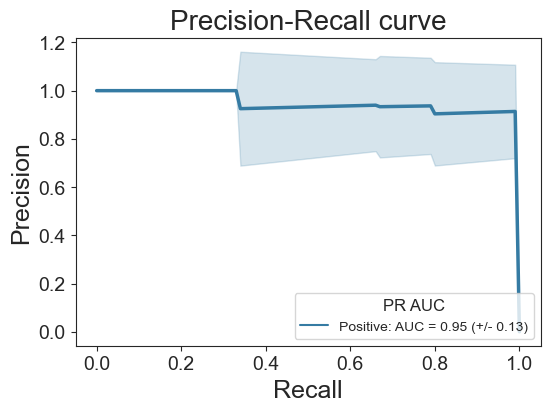

In [6]:
# Plot PR/ROC curves for each CV fold
eval_ml.plot_diagnostic_curves(df.set_index(['histopathology_id', 'val_fold']).y, 
                               y_proba, filename='bow_cv')

In [7]:
# Print optimal thresholds for each CV fold
dev.thresholds_cv(df.set_index('val_fold').y, y_proba[:,1])

# Find the optimal threshold using aggregated predictions
thresh = dev.find_optimal_threshold(y, y_proba[:,1])

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.989, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.000, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 1.000, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.000, F1-score = 0.889

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.169, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.000, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.999, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.000, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.954, F1-score = 1.000

The threshold optimises F1-score calculated from the PR

Proportion of labels predicted as:
Negative    0.88
Positive    0.12
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.98       199
    Positive       0.89      0.78      0.83        32

    accuracy                           0.96       231
   macro avg       0.93      0.88      0.90       231
weighted avg       0.96      0.96      0.96       231

PPV: 0.89, Sensitivity: 0.78, Specificity: 0.98


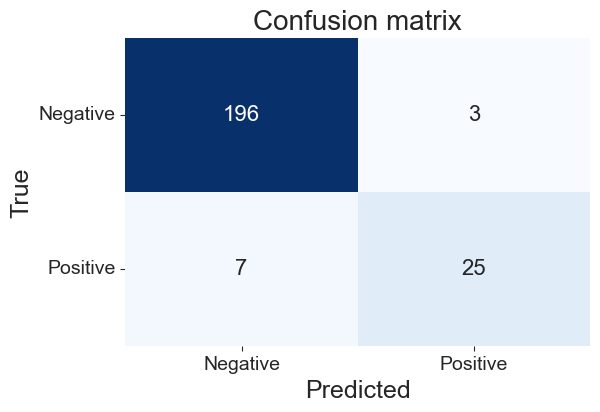

In [8]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification using aggregated predictions
eval_ml.evaluate_classification(df.y, y_pred)

### Train the final model on the full development set

In [9]:
# Re-train the final model on the full training set
best_model.fit(X, y)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, stop_words='english')),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=6, n_estimators=400,
                                            random_state=42, subsample=0.3))])

In [10]:
best_model[0].get_feature_names_out().shape

(1657,)

### Test the final model on test data

In [11]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Rename label column
df_test.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df_test.y = labels2cat(df_test.y)

# Clean text
df_test['clean_text'] = df_test.order_results.apply(text.clean_text)

# Define test set features and labels
X_test = df_test.clean_text 
y_test = df_test.y.cat.codes

# Make predictions
y_proba = best_model.predict_proba(X_test)

df_test.y.value_counts()

y
Negative    44
Positive     8
Name: count, dtype: int64

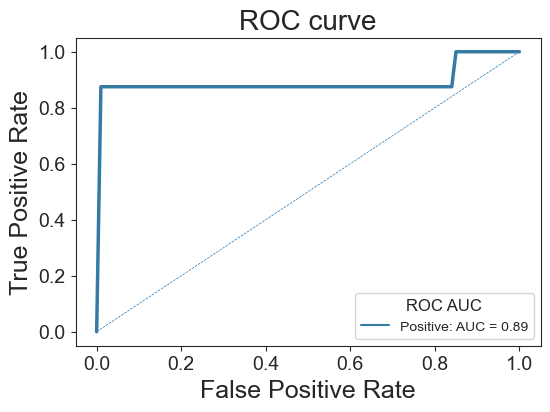

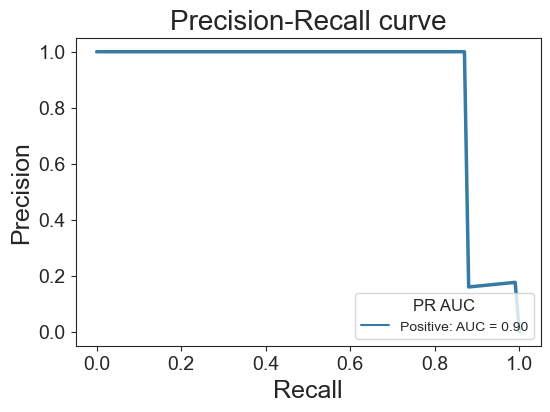

In [12]:
eval_ml.plot_diagnostic_curves(df_test.set_index(['histopathology_id', 'val_fold']).y,
                               y_proba, filename='bow_test')

Proportion of labels predicted as:
Negative    0.88
Positive    0.12
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98        44
    Positive       1.00      0.75      0.86         8

    accuracy                           0.96        52
   macro avg       0.98      0.88      0.92        52
weighted avg       0.96      0.96      0.96        52

PPV: 1.00, Sensitivity: 0.75, Specificity: 1.00


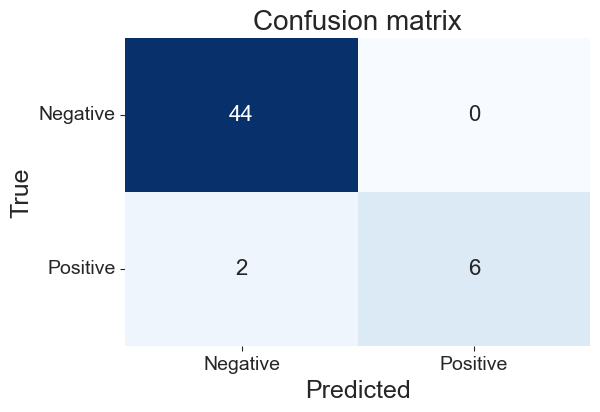

In [13]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification
eval_ml.evaluate_classification(df_test.y, y_pred, filename="bow_test")